In [151]:
#import relevant libraries
import pystan
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

## 1. Call center data set 
Exponential likelihood with a gamma prior. Estimate the number
of calls per minute for the 13th hour of the call center data set
Results to compute:

○ Posterior 98% confidence interval over λ 

○ Histogram of posterior λ samples



In [152]:

waiting_times_day = np.loadtxt('call_center.csv')

current_time = 0
waiting_times_per_hour = [[] for _ in range(24)]  # Make 24 empty lists, one per hour
for t in waiting_times_day:
    current_hour = int(current_time // 60)
    current_time += t
    waiting_times_per_hour[current_hour].append(t)
    
#13th hour
waiting_13 = waiting_times_per_hour[13]

# For Stan we provide all known quantities as data, namely the observed data
# and our prior hyperparameters.
call_stan_data = {
        'alpha': 1,  # fixed prior hyperparameters for the
        'beta': 0.25,   # gamma distribution
        'waiting_time': waiting_13,  # length of each waiting time
        'N': len(waiting_13), # number of calls in the 13th hour
}

In [153]:
call_stan_code = """

// The data block contains all known quantities - typically the observed
// data and any constant hyperparameters.

data {  
    int<lower=0> N;  // number of waiting times/calls
    real<lower=0> waiting_time[N];  // length of waiting time for each call
    real<lower=0> alpha;  // fixed prior hyperparameter 
    real<lower=0> beta;   // for gamma prior
}

// The parameters block contains all unknown quantities - typically the
// parameters of the model. Stan will generate samples from the posterior
// distributions over all parameters.

parameters {
    real<lower=0> lambda;  // call rate (num. of calls a minute)
}

// The model block contains all probability distributions in the model.
// Think of this as specifying the generative model for the scenario.

model {
  lambda ~ gamma(alpha, beta);  // gamma prior
  waiting_time ~ exponential(lambda);  // likelihood function
}

"""

In [155]:
call_center_stan_model = pystan.StanModel(model_code=call_stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7f2b05df47eeb038be8e8e66c824311e NOW.


In [156]:
call_stan_results = call_center_stan_model.sampling(data= call_stan_data)
print(call_stan_results)

Inference for Stan model: anon_model_7f2b05df47eeb038be8e8e66c824311e.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
lambda   6.35  8.8e-3   0.32   5.73   6.12   6.34   6.56   6.99   1334    1.0
lp__   324.43    0.02   0.67 322.48 324.27 324.69 324.87 324.92   2003    1.0

Samples were drawn using NUTS at Fri Feb 21 13:42:01 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


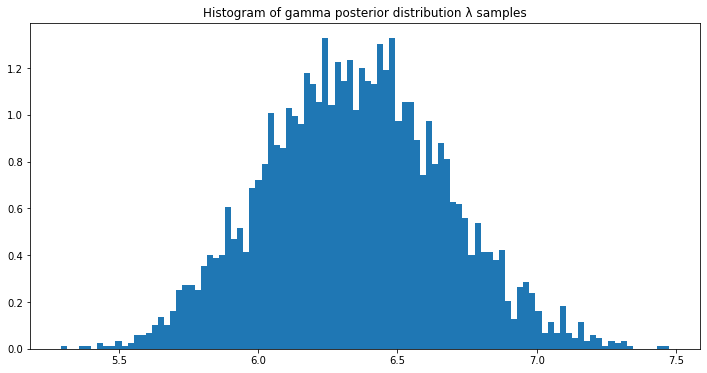

In [157]:
#extract samples from posterior gamma distribution
call_posterior_samples = call_stan_results.extract()

#Histogram of posterior λ samples
plt.figure(figsize=(12, 6))
plt.hist(call_posterior_samples['lambda'], bins=100, density=True)
plt.title('Histogram of gamma posterior distribution λ samples')
plt.show()

In [158]:
#Posterior 98% confidence interval over λ 
print(
    "Posterior 98% confidence interval over λ:",
    np.percentile(call_posterior_samples['lambda'], [1, 99]))

Posterior 98% confidence interval over λ: [ 5.64814369  7.11145997]


## 2. Normal likelihood with normal-inverse-gamma prior.
Results to compute:

○ 95% posterior confidence intervals for the mean μ and variance σ^2 of the data.

○ Take 10 samples from your posterior over μ and σ^2 and plot the normal
distributions corresponding to them. See Task 3 in the solutions below — you should
produce a plot similar to the one you find there

In [26]:
norm_data = np.array([3.54551763569501, 4.23799861761927, 4.72138425951628, -0.692265320368236, 3.04473513808788, 3.10721270732507, 3.42982225852764, 3.12153903971176, 3.60532628639808, 2.46561737557325, 1.64059465916131, 2.4621623937158, 2.76744495617481, 2.11580054750407, 5.14077208608354, 4.90288499104252, 1.43357579078348, 4.78997817363558, 1.93633438207439, 2.43698838097178, 3.95389148701877, 2.4242295507716, 2.90256268679023, 2.90931728045901, 0.658072819386888, 3.05946763895983, 3.42615331539605, 2.68842833004417, 2.35850130765166, 2.20014998540933, 4.73846511350084, 4.19839721414451, 2.11805510171691, -0.572742936038015, 0.389413982010623, 3.87846130744249, 1.34057656890858, 0.7235748351719, 5.11042369840174, 4.00747556696571, 3.18080956726965, 3.24677964069676, 5.1154659863626, 1.80276616697155, 0.305877679021404, -0.449168307882718, 4.63705561194774, 1.37783714058301, 4.9608149859515, 6.7764195802069, 1.75515522922399, 7.04457337435215, 0.625185284955128, 2.25130734369064, 2.19770178119255, 2.16858257249432, 6.25367644481438, 0.116081323476489, 2.06315857864341, 1.82409781471718, 5.15226741230987, 2.03408231293173, -1.12450854337596, 5.03511270642234, 2.03841989653263, 5.80911741751597, 2.31718128783245, 4.97575010580997, 3.34262752222776, -0.786983904253601, 0.777362359850013, 0.975825009321195, 3.76354577515958, 7.27215002907876, 1.35404089480189, 3.76567940257157, 3.48573993343334, 1.85976988586156, 1.93567061960716, 5.31071812003942, 2.96832987672751, 3.32378908637275, 2.61631960054551, 5.80897964052825, 4.95215217171488, 1.32036772796131, 3.79932542233371, 3.08108492766309, 2.6734110081666, -0.14251851138521, 2.48744375588965, 3.98463042123415, 6.32781680028, 4.0029172024315, 4.23210369459457, 1.71412938967325, 5.16492114963802, 2.53409673107906, 4.77346963973334, 3.34088878725551, 4.77681472750664, 3.81135755590976, 1.14054269983137, 1.42057452397702, 0.132142311125433, 7.12577254064672, 4.85422012781764, 4.15745720676399, 4.48763147363348, 1.56060322283629, 2.64821761542887, 1.26655351354548, 4.48497722937931, 4.3286302403783, 4.26157679512625, 4.0597558651364, 5.14051109132496, 2.5660348362221, 1.10764013818617, 0.386889523012303, 3.54150473246237, 3.57480214382351, 1.95150869584847, 2.70688970563118, 2.47971849820016, 6.50838037000679, 4.01511556826974, 1.11562740835344, 5.02637639472439, 4.38184491686864, 5.60423144047386, 2.40067408379298, 5.7849941378344, 2.37225791084559, 6.86031465910273, 4.09214858239736, 6.85994063692621, 3.62202415158781, -1.11220646958158, 3.73920971696866, 3.24533871512216, 1.28724203643002, 0.291152541773164, 0.368630935755111, 6.71607270510525, 5.42278455200833, 5.35188416119281, 2.305874586163, -1.85878097203032, 2.69877382351447, 4.84121860550417, 4.40973060799391, 5.04399320650774, 2.68632252661298, 6.06531610659912, 3.11881325011993, 3.45532087005125, 3.08442259840346, 4.43564424136733, 2.84252623135804, 1.50536798885106, 1.48868622407603, 2.07322837615663, 2.5476910210998, 5.66941808257884, 2.16731067416426, 2.49843958833905, 3.94586413879977, 0.316433764679541, -0.608937441815983, 2.5943436558557, 1.05516869528337, 2.1447601332725, 6.65846634141906, 2.1771555267834, 5.23953812029442, 3.53629759842647, 6.03263538017003, 3.85739159396599, 5.95093453004638, 1.12856987160476, 3.5559912886093, 2.21974864244489, 3.38471394882135, -1.90805399279409, 3.5113699258973, 4.49319955412346, 5.10507952638867, 1.08277895384184, 4.58403638422759, 1.37304994426824, 4.17566975753523, 3.36454182510378, 0.177136582644021, 2.91337423388405, 3.22796455457526, 2.80124198378441, 1.95189718582788, 3.37659263896246, -1.6463045238231])

In [145]:
norm_stan_data = {
        'mu': 0,  # prior hyperparamter mu
        'nu': 0.054,   # prior hyperparamter nu 
        'alpha': 1.12,   # prior hyperparamters alpha and beta which
        'beta': 0.4,       # govern the marginal prior over the variance.
        'norm_data': norm_data,  # length of each waiting time
        'N': len(norm_data), # number of calls in the 13th hour
}

In [159]:
norm_stan_code = """

// The data block contains all known quantities - typically the observed
// data and any constant hyperparameters.

data {  
    int<lower=0> N;  // 
    real norm_data[N];  //  data
    real<lower=0> mu;  // fixed prior hyperparameter 
    real<lower=0> nu;   // fixed prior hyperparameter 
    real<lower=0> alpha;  // fixed prior hyperparameter 
    real<lower=0> beta;   // fixed prior hyperparameter 
}

// The parameters block contains all unknown quantities - typically the
// parameters of the model. Stan will generate samples from the posterior
// distributions over all parameters.

parameters {
    real mean_0;  // mean of data
    real<lower=0> var_0;   // variance of data
}

// The model block contains all probability distributions in the model.
// Think of this as specifying the generative model for the scenario.

model {
    mean_0 ~ normal(mu, sqrt(var_0/nu));
    var_0 ~ inv_gamma(alpha, beta);
    for(i in 1:N) {
        norm_data[i] ~ normal(mean_0, sqrt(var_0));  // likelihood function
  }
}

"""

In [160]:
norm_stan_model = pystan.StanModel(model_code=norm_stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2c5f7977639b671a9933d1e46f4d439e NOW.


In [161]:
norm_stan_results = norm_stan_model.sampling(data=norm_stan_data)
print(norm_stan_results)

Inference for Stan model: anon_model_2c5f7977639b671a9933d1e46f4d439e.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mean_0   3.06  2.5e-3   0.14   2.79   2.97   3.07   3.16   3.33   3097    1.0
var_0    3.62  6.0e-3   0.36   2.96   3.36    3.6   3.85   4.41   3747    1.0
lp__   -233.2    0.02   1.02 -236.0 -233.6 -232.9 -232.5 -232.2   1935    1.0

Samples were drawn using NUTS at Fri Feb 21 13:45:38 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


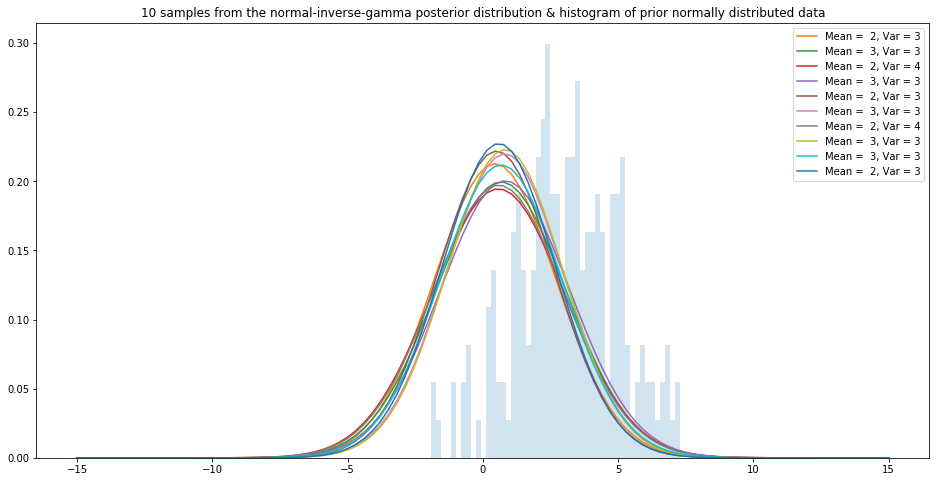

In [163]:
#extract samples from posterior norm inv gamma distribution
norm_posterior_samples = norm_stan_results.extract()

#generate 10 samples of mean and variance
mean_samples = np.random.choice(norm_posterior_samples['mean_0'], 10 )
var_samples = np.random.choice(norm_posterior_samples['var_0'], 10)

# Plot the normal distributions corresponding to the samples
plt.figure(figsize=(16, 8))
x = np.linspace(-15, 15, 100)
plt.hist(norm_data, bins=50,density=True, alpha = 0.2)
for i in range(10):
    y = stats.norm.pdf(plot_x, loc=mean_samples[i], scale=np.sqrt(var_samples[i]))
    plt.plot(x, y, label= 'Mean =  %i, Var = %i' % (mean_samples[i],var_samples[i]))
plt.title('10 samples from the normal-inverse-gamma posterior distribution & histogram of prior normally distributed data')
plt.legend() # Show the legend in the top right corner
plt.show()

In [165]:
#Posterior 95% confidence interval over mean μ and variance σ^2:
print(
    "Posterior 95% confidence interval over mean μ:",
    np.percentile(norm_posterior_samples['mean_0'], [2.5, 97.5])
)
print(
    "Posterior 95% confidence interval over variance σ:",
    np.percentile(norm_posterior_samples['var_0'], [2.5, 97.5]),
)

Posterior 95% confidence interval over mean μ: [ 2.79175285  3.3280741 ]
Posterior 95% confidence interval over variance σ: [ 2.95955514  4.4080568 ]


## 3 Log-normal HRTEM data
Normal likelihood log-transformed data and using a normal-inverse-gamma prior.

Results to compute:

● 95% posterior confidence intervals for the μ and variance σ^2 of the log-transformed
data. (Should match results under Task 3 of the solutions.)

● Take 10 samples from your posterior over μ and σ^2 and plot the log-normal
distributions corresponding to them. See Task 5 in the solutions below — you should
produce a plot similar the one you find there, but with 10 pdfs rather than one.

In [104]:
#load dataset
hrtem = np.loadtxt('hrtem.csv')

#perform log transformation on data
log_data = np.log(hrtem)

#verify transformation
print("original data:", hrtem[:3])
print("log-transformed data:", log_data[:3])

hrtem_data = {
                'log_data': log_data,
                'N': len(log_data),
                'mu': 2.3, # fixed prior hyperparameters
                'nu': 0.1, # fixed prior hyperparameters
                'alpha': 2, # fixed prior hyperparameters
                'beta': 5 # fixed prior hyperparameters
              }

original data: [ 1.86113123  1.25956995  1.05182743]
log-transformed data: [ 0.62118449  0.23077035  0.05052906]


In [105]:
hrtem_stan_code = """

// The data block contains all known quantities - typically the observed
// data and any constant hyperparameters.

data {  
    int<lower=0> N;  // data length
    real log_data[N];  //  data
    real<lower=0> mu;  // fixed prior hyperparameter 
    real<lower=0> nu;   // fixed prior hyperparameter 
    real<lower=0> alpha;  // fixed prior hyperparameter 
    real<lower=0> beta;   // fixed prior hyperparameter 
}

// The parameters block contains all unknown quantities - typically the
// parameters of the model. Stan will generate samples from the posterior
// distributions over all parameters.

parameters {
    real mean_0;  // mean of data
    real<lower=0> var_0;   // variance of data
}

// The model block contains all probability distributions in the model.
// Think of this as specifying the generative model for the scenario.

model {
    mean_0 ~ normal(mu, sqrt(var_0/nu));
    var_0 ~ inv_gamma(alpha, beta);
    for(i in 1:N) {
        log_data[i] ~ normal(mean_0, sqrt(var_0));  // likelihood function
  }
}

"""

In [106]:
hrtem_stan_model = pystan.StanModel(model_code=hrtem_stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6a95feb2453a26b6b866749c051b7850 NOW.


In [107]:
hrtem_stan_results = hrtem_stan_model.sampling(data=hrtem_data)
print(hrtem_stan_results)

Inference for Stan model: anon_model_6a95feb2453a26b6b866749c051b7850.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mean_0   1.89  5.0e-4   0.03   1.83   1.87   1.89   1.91   1.96   3942    1.0
var_0     0.5  5.4e-4   0.03   0.44   0.47   0.49   0.52   0.56   3402    1.0
lp__   -76.02    0.02   0.99 -78.68 -76.41 -75.74 -75.32 -75.04   1962    1.0

Samples were drawn using NUTS at Fri Feb 21 12:43:49 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


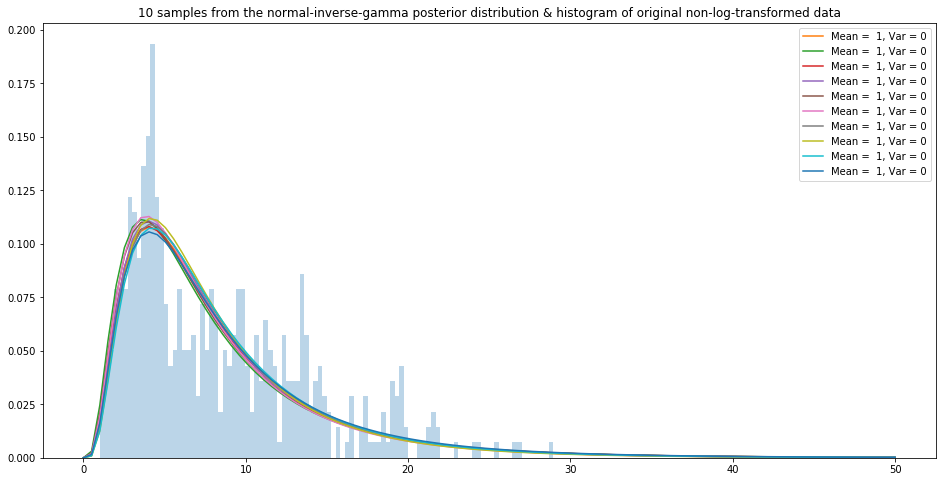

In [135]:
#extract samples from posterior norm inv gamma distribution
hrtem_posterior_samples = hrtem_stan_results.extract()

#generate 10 samples of mean and variance
mean_samples = np.random.choice(hrtem_posterior_samples['mean_0'], 10 )
var_samples = np.random.choice(hrtem_posterior_samples['var_0'], 10)

# Plot the normal distributions corresponding to the samples
plt.figure(figsize=(16, 8))
x = np.linspace(0, 50, 100)
plt.hist(hrtem, bins=100, density=True,alpha = 0.3)
for i in range(10):
    y = stats.lognorm.pdf(x, np.sqrt(var_samples[i]), scale=np.exp(mean_samples[i]))
    plt.plot(x, y, label= 'Mean =  %i, Var = %i' % (mean_samples[i],var_samples[i]))
plt.title('10 samples from the normal-inverse-gamma posterior distribution & histogram of original non-log-transformed data')
plt.legend() # Show the legend in the top right corner
plt.show()

In [137]:
#Posterior 95% confidence interval over mean μ and variance σ^2:

print(
    "Posterior 95% confidence interval for mean μ:",
    np.percentile(hrtem_posterior_samples['mean_0'], [2.5, 97.5])
)
print(
    "Posterior 95% confidence interval for variance σ^2:",
    np.percentile(hrtem_posterior_samples['var_0'], [2.5, 97.5]),
)

Posterior 95% confidence interval for mean μ: [ 1.83154836  1.9552895 ]
Posterior 95% confidence interval for variance σ^2: [ 0.43842435  0.55792255]
